In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [69]:
import nest_asyncio
import uuid
import torch
from vllm import AsyncEngineArgs, AsyncLLMEngine, SamplingParams
from pprint import pprint
import json
import re

from qdrant_client import QdrantClient
from qdrant_client.models import PointStruct

from langgraph.graph import StateGraph
from langsmith import traceable

from typing_extensions import TypedDict 

from pydantic import BaseModel, Field
from typing import List, Dict, Optional, Annotated

from transformers import AutoTokenizer, AutoModel


# 이벤트 루프 충돌 방지
nest_asyncio.apply()

In [4]:
tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-m3")
model = AutoModel.from_pretrained("BAAI/bge-m3")
model.eval()

XLMRobertaModel(
  (embeddings): XLMRobertaEmbeddings(
    (word_embeddings): Embedding(250002, 1024, padding_idx=1)
    (position_embeddings): Embedding(8194, 1024, padding_idx=1)
    (token_type_embeddings): Embedding(1, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): XLMRobertaEncoder(
    (layer): ModuleList(
      (0-23): 24 x XLMRobertaLayer(
        (attention): XLMRobertaAttention(
          (self): XLMRobertaSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): XLMRobertaSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-05, elem

In [5]:
gemma = "/home/mmm060400/KTB/models/google/gemma-3-4b-it/"

engine_args = AsyncEngineArgs(
    model=gemma,
    tensor_parallel_size=1,
    gpu_memory_utilization=0.95,
    max_num_seqs = 100,
    max_model_len=4096,
    max_num_batched_tokens=8192
)
llm = AsyncLLMEngine.from_engine_args(engine_args)

INFO 05-04 16:06:48 [config.py:600] This model supports multiple tasks: {'classify', 'score', 'embed', 'reward', 'generate'}. Defaulting to 'generate'.
INFO 05-04 16:06:48 [config.py:1780] Chunked prefill is enabled with max_num_batched_tokens=8192.
INFO 05-04 16:06:51 [core.py:61] Initializing a V1 LLM engine (v0.8.3) with config: model='/home/mmm060400/KTB/models/google/gemma-3-4b-it/', speculative_config=None, tokenizer='/home/mmm060400/KTB/models/google/gemma-3-4b-it/', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar', reasoning_backend=None), observability_config=Observability

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


INFO 05-04 16:07:00 [gpu_model_runner.py:1258] Starting to load model /home/mmm060400/KTB/models/google/gemma-3-4b-it/...
INFO 05-04 16:07:00 [config.py:3334] cudagraph sizes specified by model runner [1, 2, 4, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160, 168, 176, 184, 192, 200, 208, 216, 224, 232, 240, 248, 256, 264, 272, 280, 288, 296, 304, 312, 320, 328, 336, 344, 352, 360, 368, 376, 384, 392, 400, 408, 416, 424, 432, 440, 448, 456, 464, 472, 480, 488, 496, 504, 512] is overridden by config [512, 384, 256, 128, 4, 2, 1, 392, 264, 136, 8, 400, 272, 144, 16, 408, 280, 152, 24, 416, 288, 160, 32, 424, 296, 168, 40, 432, 304, 176, 48, 440, 312, 184, 56, 448, 320, 192, 64, 456, 328, 200, 72, 464, 336, 208, 80, 472, 344, 216, 88, 120, 480, 352, 248, 224, 96, 488, 504, 360, 232, 104, 496, 368, 240, 112, 376]
WARNING 05-04 16:07:01 [topk_topp_sampler.py:69] FlashInfer is not available. Falling back to the PyTorch-native implementation of top-p & to

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 05-04 16:07:03 [loader.py:447] Loading weights took 2.46 seconds
INFO 05-04 16:07:03 [gpu_model_runner.py:1273] Model loading took 8.5833 GiB and 2.685266 seconds
INFO 05-04 16:07:03 [gpu_model_runner.py:1542] Encoder cache will be initialized with a budget of 8192 tokens, and profiled with 32 image items of the maximum feature size.
INFO 05-04 16:07:24 [backends.py:416] Using cache directory: /home/mmm060400/.cache/vllm/torch_compile_cache/90ec895879/rank_0_0 for vLLM's torch.compile
INFO 05-04 16:07:24 [backends.py:426] Dynamo bytecode transform time: 14.75 s
INFO 05-04 16:07:25 [backends.py:115] Directly load the compiled graph for shape None from the cache
INFO 05-04 16:07:36 [monitor.py:33] torch.compile takes 14.75 s in total
INFO 05-04 16:07:38 [kv_cache_utils.py:578] GPU KV cache size: 57,792 tokens
INFO 05-04 16:07:38 [kv_cache_utils.py:581] Maximum concurrency for 4,096 tokens per request: 14.11x
INFO 05-04 16:08:08 [gpu_model_runner.py:1608] Graph capturing finished in 

In [6]:
sampling_params = SamplingParams(temperature=0.6, top_p=0.7, repetition_penalty=1.1, max_tokens=4096, stop = ["<eos>"])


# 비동기 LLM 실행 (non-streaming)
async def llm_engine(prompt: str) -> str:
    request_id = str(uuid.uuid4())
    last_output = None

    async for output in llm.generate(
        prompt=prompt,
        sampling_params=sampling_params,
        request_id=request_id
    ):
        last_output = output.outputs[0].text  # ✅ 덮어쓰기만 함

    return last_output if last_output is not None else ""



async def llm_til(prompt: str) -> str:
    try:
        result = await llm_engine(prompt)
        return result
    except Exception as e:
        print(f"❌ LLM 호출 실패: {e}")
        return "[LLM 호출 실패]"

In [7]:
# JSON 파일 읽기
with open("/home/mmm060400/KTB/Data/response_dia.json", 'r', encoding='utf-8') as file:
    data = json.load(file)
data

{'username': 'ConconDev',
 'date': '2024-09-06',
 'repo': 'backend',
 'files': [{'filepath': 'src/main/java/com/sookmyung/concon/Alarm/controller/AlarmController.java',
   'latest_code': 'import com.sookmyung.concon.Alarm.service.AlarmService;\nimport lombok.RequiredArgsConstructor;\nimport org.springframework.http.MediaType;\nimport org.springframework.http.ResponseEntity;\nimport org.springframework.web.bind.annotation.GetMapping;\nimport org.springframework.web.bind.annotation.RequestHeader;\nimport org.springframework.web.bind.annotation.RestController;\nimport org.springframework.web.servlet.mvc.method.annotation.SseEmitter;\n\n@RestController("/api/alarm")\n@RequiredArgsConstructor\npublic class AlarmController {\n    private final AlarmService alarmService;\n\n    @GetMapping(value = "/subscribe", produces = MediaType.TEXT_EVENT_STREAM_VALUE)\n    public ResponseEntity<SseEmitter> subscribe(\n            @RequestHeader("Authorization") String token) {\n        return ResponseEnt

In [ ]:
from pydantic import BaseModel, Field
from typing import List, Dict, Optional, Annotated
from functools import reduce

In [114]:
def merge_dicts(x: dict, y: dict) -> dict:
    if x is None:
        return y
    if y is None:
        return x
    return {**x, **y}


class PatchModel(BaseModel):
    commit_message: str
    patch: str


class FileModel(BaseModel):
    filepath: str
    latest_code: str
    patches: List[PatchModel]


class TilJsonModel(BaseModel):
    username: str
    date: str
    repo: str
    title: str
    keywords: List[str]
    content: str
    vector: List[float]


class StateModel(BaseModel):
    username: str
    date: str
    repo: str
    files: List[Dict]  # node_id가 포함된 파일 리스트

    # 선택 필드들 (초기엔 없을 수 있음)
    code_summary: Annotated[Dict[str, str], merge_dicts] = Field(default_factory=dict)
    patch_summary: Annotated[Dict[str, str], merge_dicts] = Field(default_factory=dict)
    til_draft: Optional[str] = None
    til_final: Optional[str] = None
    til_json: Optional[TilJsonModel] = None

In [115]:
@traceable
def fork_code_nodes(state: dict):
    # print(state)
    
    files = state.files
    
    # files 리스트를 새로운 형태로 업데이트
    updated_files = [
        {
            "file": file,    # file 하나
            "node_id": i + 1  # node 번호 부여
        }
        for i, file in enumerate(files)
    ]
    
    state_dict = state.model_dump()
    state_dict["files"] = updated_files
    return StateModel(**state_dict)

## 프롬프트 함수(Legacy)

In [116]:
# # code summary 함수
# def make_code_summary_prompt(file: dict) -> str:
#     filepath = file["filepath"]
#     latest_code = file["latest_code"]

#     prompt = f"""
# 다음은 소프트웨어 프로젝트의 하나의 소스코드 파일입니다.
# 이 코드는 어떤 역할을 수행하며, 어떤 기능이나 책임을 가지고 있는지 요약해 주세요.

# 파일 전체를 기반으로 아래 항목을 중심으로 분석해주세요:
# 1. 이 파일은 어떤 기술 스택(프레임워크, 언어 등)을 사용하나요?
# 2. 이 코드의 주요 기능 또는 목적은 무엇인가요?
# 3. 이 코드가 프로젝트 전체에서 어떤 책임을 맡고 있는지 추론해 주세요.

# 파일 경로:
# {filepath}

# 코드:
# {latest_code}
# """
#     return prompt

# # patch summary 함수
# def make_patch_summary_prompt(code_summary: str, patch_section: str) -> str:
#     prompt = f"""
# 다음은 소프트웨어 프로젝트에서 작성된 하나의 소스코드 파일에 대한 분석 결과입니다:

# [코드 요약]
# {code_summary}

# 이 코드는 다음과 같은 변경 사항(patch)들을 거쳐 최종 형태로 완성되었습니다.  
# 각 변경 사항이 기존 코드 구조에 어떤 기능을 추가하거나 문제를 해결했는지 분석해주세요.  
# 또한 전체적인 변경 흐름에서 어떤 순차적 의미나 패턴이 있는지도 함께 설명해주세요.
# 코드 자체의 특징만 분석해주세요. 추가 개선점은 필요 없습니다.

# [변경 이력 목록]
# {patch_section}

# 요약 포맷 예시:
# 1. 각 patch가 기존 구조에 어떤 영향을 주었는지
# 2. 어떤 기능이 추가되었으며, 왜 필요한 변경이었는지
# 3. 변경의 흐름 상 어떤 순서를 갖는지
# 4. 이러한 변경의 목적이 무엇이었는지
# 5. 코드 변경으로 인해 얻을 수 있는 효과

# 답변은 전체적으로 한국어로 작성해 주세요. 코드 분석 내용에 대해서는 작성하지 않아도 됩니다.
# """
#     return prompt

# # TIL 초안 생성 프롬프트
# def make_til_draft_prompt(username: str, date: str, repo: str, combined_summary: str) -> str:
#     prompt = f"""
# 다음은 하나 이상의 소스코드 파일에 대한 분석 요약과 변경 이력 분석입니다. 이를 참고하여 마크다운 형식의 TIL을 작성해 주세요.

# [코드 + 변경 요약]
# {combined_summary}

# 요구 조건:
# - 다음 형식의 JSON으로 작성:
# {{
#   "user": "{username}",
#   "date": "{date}",
#   "repo": "{repo}",
#   "title": "<{date} 포함 제목>",
#   "keywords": ["<핵심 기술 키워드 1~3개>"],
#   "content": "<마크다운 형식 TIL>"
# }}

# TIL 작성 시 반드시 포함할 항목 (개조식):
# 1. 오늘 배운 내용
# 2. 개념 정리
# 3. 해당 개념이 필요한 이유
# 4. 개념을 활용하는 방법
# 5. 문제 해결 과정
# 6. 하루 회고
# 7. 전체적으로 개조식 문장 구성

# TIL 내용은 한국어로 작성하세요.
# """
#     return prompt

In [117]:
# code summary 함수
def make_code_summary_prompt(file: dict) -> str:
    filepath = file["filepath"]
    latest_code = file["latest_code"]

    prompt = f"""
다음은 소프트웨어 프로젝트의 하나의 소스코드 파일입니다.
주어진 코드를 분석하여 핵심 내용을 간단한 개조식 문장으로 요약해 주세요.

요약 항목:
- 사용 기술 스택 (언어, 프레임워크)
- 주요 기능
- 프로젝트 내 기능

요약은 다음처럼 개조식으로 작성해 주세요:

예시:
- 언어: Python, 프레임워크: FastAPI
- 기능: 사용자 인증 처리
- 기능: API 서버 인증 모듈 담당

[파일 경로]
{filepath}

[코드]
{latest_code}
"""
    return prompt

# patch summary 함수
def make_patch_summary_prompt(code_summary: str, patch_section: str) -> str:
    prompt = f"""
다음은 하나의 소스코드 파일에 대한 코드 요약과 변경 이력입니다.
변경 이력(patch)을 바탕으로 변경 목적과 주요 수정사항을 간단한 개조식 문장으로 요약해 주세요.

[코드 요약]
{code_summary}

[변경 이력]
{patch_section}

요약 항목:
- 주요 변경 목적
- 핵심 수정사항 요약
- 변경 흐름 요약 (필요 시)

요약은 다음처럼 개조식으로 작성해 주세요:

예시:
- 기능 추가: OAuth 인증 모듈 도입
- 버그 수정: 로그인 세션 만료 문제 해결
- 구조 개선: Controller 레이어 분리

답변은 한국어로, 개조식 문장으로만 작성하세요.
"""
    return prompt


# TIL 초안 생성 프롬프트

# TIL 초안 생성 프롬프트
def til_draft_prompt(username: str, date: str, repo: str, combined_summary: str) -> str:
    prompt = f"""
다음은 하나 이상의 소스코드 파일에 대한 분석 요약과 변경 이력 분석입니다. 이를 참고하여 마크다운 형식의 TIL을 작성해 주세요.

[코드 + 변경 요약]
{combined_summary}

요구 조건:
- 다음 형식의 JSON으로 작성:
{{
  "user": "{username}",
  "date": "{date}",
  "repo": "{repo}",
  "title": "<{date} 포함 제목>",
  "keywords": ["<핵심 기술 키워드 1~3개>"],
  "content": "<마크다운 형식 TIL>"
}}

TIL 작성 시 반드시 포함할 항목 (개조식):
1. 오늘 배운 내용
2. 개념 정리
3. 해당 개념이 필요한 이유
4. 개념을 활용하는 방법
5. 문제 해결 과정
6. 하루 회고
7. 전체적으로 개조식 문장 구성

TIL 내용은 한국어로 작성하세요.
"""
    return prompt

# 피드백 루프
def til_feedback_prompt(content: str) -> str:
    """
    TIL 초안을 받아서 개선 지침을 포함한 feedback prompt를 생성합니다.

    Args:
        content (str): 초안 TIL 내용 (마크다운 텍스트)

    Returns:
        str: LLM에게 전달할 최종 프롬프트 텍스트
    """
    feedback_prompt = f"""
다음은 오늘 학습한 내용을 정리한 TIL 초안입니다.

[TIL 초안]
{content}

이 TIL을 다음 기준에 따라 평가하고, 더 구체적이고 일관성 있는 TIL로 개선해 주세요:

✅ 개선 기준:
1. **중복 문장 제거** – 유사하거나 반복되는 문장은 하나로 합쳐 주세요.
2. **표현의 명확성** – 불분명하거나 모호한 표현을 구체적으로 바꿔 주세요.
3. **개조식 통일** – 문장형 서술이 있다면 개조식으로 정리해 주세요.
4. **불필요한 서론 제거** – 지나치게 일반적이거나 반복되는 내용은 생략해 주세요.
5. **자주 사용되는 추상 표현 제거** – "새로운 면모", "실감나게", "꾸준히", "흥미로웠다" 등의 모호한 감정/상태 표현은 구체적인 행동, 성과, 계획으로 바꿔 주세요.
6. **자연스러운 문장 구성** – 한국어 맞춤법 및 어투를 자연스럽게 다듬어 주세요. 문장이 너무 길어지면 줄바꿈으로 구조를 직관적으로 보이게 작성하세요.

✅ 출력 형식:
- 수정된 TIL 전체 (마크다운 형식 유지)

**주의**: 결과는 반드시 한국어로 작성해 주세요. 초안에 대한 피드백 부분은 작성하지 마세요. **TIL 본문만 필요합니다.**
"""
    return feedback_prompt


In [118]:
def make_code_summary_node(node_id: int):
    @traceable(run_type="llm")
    async def code_summary_node(state: dict):
        files = state.files
        file_entry = next(file for file in files if file["node_id"] == node_id)
        file = file_entry["file"]

        prompt = make_code_summary_prompt(file)
        summary = await llm_til(prompt)

        return {"code_summary": {f"code_summary_{node_id}": summary}}
    return code_summary_node


In [119]:
def make_patch_summary_node(node_id: int):
    @traceable(run_type="llm")
    async def patch_summary_node(state: dict):
        files = state.files

        file_entry = next(file for file in files if file["node_id"] == node_id)
        file = file_entry["file"]

        code_summaries = state.code_summary
        code_summary = code_summaries.get(f"code_summary_{node_id}", "")

        patches = file.get("patches", [])
        if not patches:
            return {"patch_summary": {f"patch_summary_{node_id}": f"{code_summary}\n\n(변경 이력 없음)"}}
        
        patch_section = "\n\n".join(
            f"{j+1}. Commit Message: {p['commit_message']}\nPatch:\n{p['patch']}"
            for j, p in enumerate(patches)
        )

        prompt = make_patch_summary_prompt(code_summary, patch_section)
        summary = await llm_til(prompt)

        return {"patch_summary": {f"patch_summary_{node_id}": summary}}
    return patch_summary_node


In [120]:
def clean_code_block(text: str) -> str:
    # ```json ~ ``` 블록 제거
    cleaned = re.sub(r"^```json\s*|\s*```$", "", text.strip(), flags=re.DOTALL)
    return cleaned

In [121]:
# format_instructions를 partial로 주입
# prompt_template = prompt_template.partial(format_instructions=parser.get_format_instructions())

# ✅ 4. til_draft_node
@traceable
async def til_draft_node(state: dict):
    username = state.username
    date = state.date
    repo = state.repo

    patch_summaries = state.patch_summary
    summaries = list(patch_summaries.values())
    combined_summary = "\n\n".join(summaries)

    prompt = til_draft_prompt(username, date, repo, combined_summary)

    draft_json_str = await llm_til(prompt)
    return {"til_draft": draft_json_str}

In [122]:
@traceable
def parse_til_to_json(state: dict) -> dict:
    til_draft = state.til_draft
    try:
        start = til_draft.find("```json")
        end = til_draft.find("```", start + 1)
        json_str = til_draft[start + 7:end].strip()
        parsed = json.loads(json_str)
        return {"til_json": parsed}
    except Exception as e:
        return {"til_json": {"error": f"JSON 파싱 실패: {str(e)}"}}

In [134]:
# qdrant-server 인스턴스 IP 입력
client = QdrantClient(host="34.46.221.240", port=6333)

@traceable
def embed_and_store_in_qdrant_node(state: dict) -> dict:
    til_json = state.til_json
    if not til_json:
        raise ValueError("til_json is missing from state")

    # 🔹 텍스트 임베딩: title + content
    title = til_json.title
    content = til_json.content
    text = f"query: {title}\n{content}"

    encoded_input = tokenizer(text, return_tensors='pt', truncation=True, padding=True)

    with torch.no_grad():
        output = model(**encoded_input)

    embedding = output.last_hidden_state.mean(dim=1)[0].tolist()

    # 🔹 payload 구성 (vector는 빼고)
    payload = {k: v for k, v in til_json.model_dump().items() if k != "vector"}

    # 🔹 Qdrant 포인트 생성 및 저장
    point = PointStruct(
        id=str(uuid.uuid4()),
        vector=embedding,
        payload=payload
    )

    client.upsert(collection_name="til_logs", points=[point])

    # 상태는 그대로 반환 (벡터는 저장에만 사용)
    return state.til_json


In [135]:
# @traceable
# async def til_feedback_node(state: dict):
#     til_draft = state["til_draft"]
#     prompt = til_feedback_prompt(til_draft)
#     print(prompt)
#     til_final = await llm_til(prompt)
#     print("🔥 [til_feedback_node] LLM 출력:", til_final)

#     return {"til_final": til_final}

In [136]:
s2 = StateModel(**data)
builder = StateGraph(StateModel)
builder.set_entry_point("fork")
builder.add_node("fork", fork_code_nodes)

# 1. 코드 요약 노드 + 패치 요약 노드 추가
for i in range(5):
    code_node_fn = make_code_summary_node(i+1)
    patch_node_fn = make_patch_summary_node(i+1)

    builder.add_node(f"code_summary_node{i+1}", code_node_fn)
    builder.add_node(f"patch_summary_node{i+1}", patch_node_fn)

    builder.add_edge("fork", f"code_summary_node{i+1}")  # fork → code
    builder.add_edge(f"code_summary_node{i+1}", f"patch_summary_node{i+1}")  # code → patch

# 2. TIL draft 노드 추가
builder.add_node("til_draft_node", til_draft_node)

# 3. 모든 patch_summary_node → til_draft_node 연결
for i in range(5):
    builder.add_edge(f"patch_summary_node{i+1}", "til_draft_node")

# builder.add_node("til_feedback_node", til_feedback_node)
# builder.add_edge("til_draft_node", "til_feedback_node")
builder.add_node("json_parse_node", parse_til_to_json)
builder.add_edge("til_draft_node", "json_parse_node")

builder.add_node("embedding_til_node", embed_and_store_in_qdrant_node)
builder.add_edge("json_parse_node", "embedding_til_node")
builder.set_finish_point("embedding_til_node")
# builder.set_finish_point("json_parse_node")

# 4. 컴파일
graph = builder.compile()

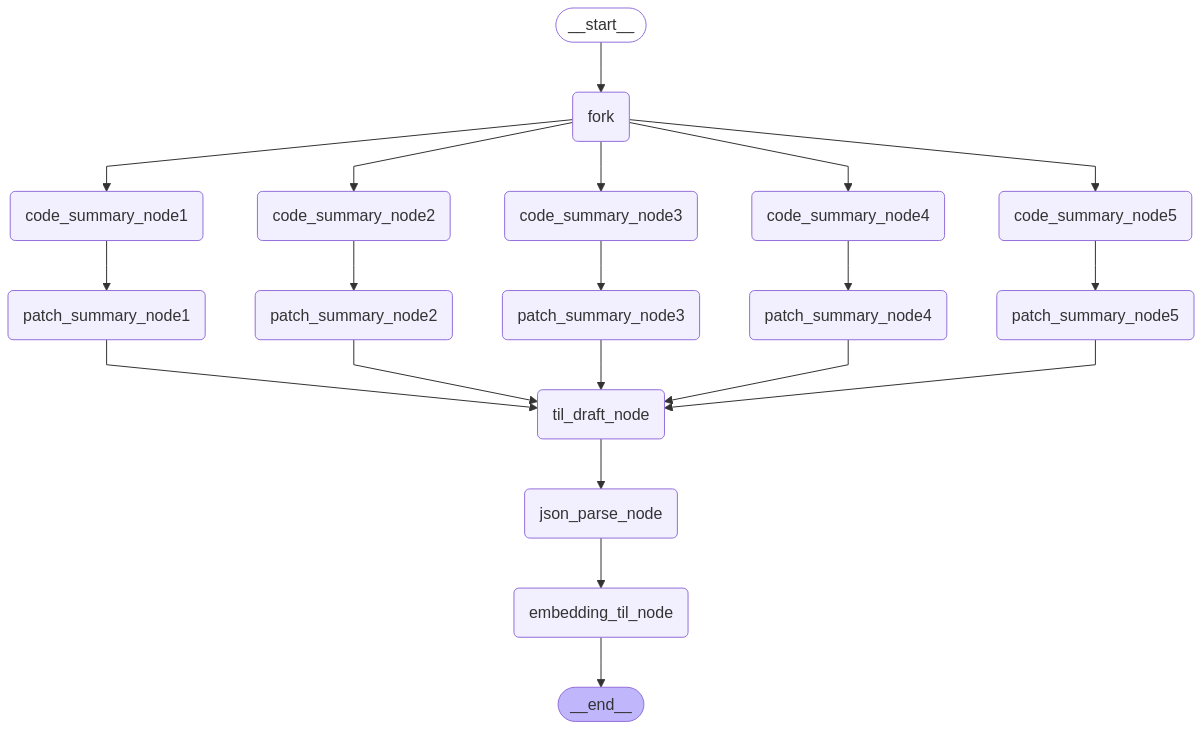

In [137]:
graph

In [139]:
result = await graph.ainvoke(s2)

INFO 05-04 16:54:00 [async_llm.py:228] Added request 55f2613f-5e9a-452a-a0d9-58b88956011d.
INFO 05-04 16:54:00 [async_llm.py:228] Added request f7dff3bd-9a3f-4441-adc9-e8dedf260146.
INFO 05-04 16:54:00 [async_llm.py:228] Added request acc87954-06cb-42c4-8a31-8323091e2e26.
INFO 05-04 16:54:00 [async_llm.py:228] Added request 39136f01-6f9c-4475-9422-1fce77c61b93.
INFO 05-04 16:54:00 [async_llm.py:228] Added request 8bd6bed4-32a9-4647-89bc-f4f3fedd3277.


INFO 05-04 16:54:11 [async_llm.py:228] Added request 9d8e899b-9cc8-45c6-826b-21189989d6a7.
INFO 05-04 16:54:11 [async_llm.py:228] Added request 5e2ad73d-b438-4f14-bf11-949393fc51e1.
INFO 05-04 16:54:11 [async_llm.py:228] Added request 20150ced-4599-45a6-9312-5ef2ac48e8ba.
INFO 05-04 16:54:11 [async_llm.py:228] Added request ab4761c5-76c7-4234-939f-13830aacf58e.
INFO 05-04 16:54:11 [async_llm.py:228] Added request 6868b081-fd82-425f-89d9-c0464331fc9c.
INFO 05-04 16:54:15 [async_llm.py:228] Added request 34e239b0-6c3a-4887-b53e-4b2e1fe18b00.


In [25]:
pprint(result["til_draft"])

('```json\n'
 '{\n'
 '  "user": "ConconDev",\n'
 '  "date": "2024-09-06",\n'
 '  "repo": "backend",\n'
 '  "title": "알람 구독 서비스 및 SSE 스트리밍 구현",\n'
 '  "keywords": ["알람 구독", "SSE", "Authorization", "SseEmitter"],\n'
 '  "content": "# 알람 구독 서비스 및 SSE 스트리밍 구현\\n\\n오늘 알람 구독 서비스를 제공하는 컨트롤러를 개발하고, '
 '서버에서 클라이언트로 실시간 데이터를 전송하기 위한 SSE(Server-Sent Events) 스트리밍 기능을 '
 '구현했습니다.\\n\\n## 1. 오늘 배운 내용\\n\\n*   **SSE:** 서버에서 클라이언트로 단방향 실시간 통신을 제공하는 웹 '
 '기술입니다. HTTP 연결을 유지하면서 서버가 새로운 데이터를 보내는 방식입니다.\\n*   **SseEmitter:** SSE 스트림을 '
 '관리하는 클래스로, 연결 관리, 메시지 전송 등을 담당합니다.\\n*   **Authorization 헤더:** 요청에 대한 인증 정보를 '
 '담고 있는 헤더입니다. JWT(JSON Web Token)를 사용하여 인증하는 경우, Authorization 헤더에 JWT 토큰을 '
 '포함합니다.\\n*   **Controller 역할:** 클라이언트의 요청을 받아 비즈니스 로직을 수행하고 응답을 반환하는 역할을 '
 '합니다.\\n\\n## 2. 개념 정리\\n\\n*   **SSE:**  웹 애플리케이션에서 서버로부터 실시간 업데이트를 제공해야 할 때 '
 '유용합니다. 예를 들어, 주식 시장 정보, 스포츠 경기 점수, 채팅 메시지 등을 실시간으로 표시할 수 있습니다.\\n*   '
 '**SseEmitter:**  SSE 스트림을 효율적으로 관리하기 위해 사용됩니다. 연결을 자동으로 관리하고, 메시지를 전송하는 데 '
 '필요한 작업을 

In [26]:
result["til_json"]

{'user': 'ConconDev',
 'date': '2024-09-06',
 'repo': 'backend',
 'title': '알람 구독 서비스 및 SSE 스트리밍 구현',
 'keywords': ['알람 구독', 'SSE', 'Authorization', 'SseEmitter'],
 'content': '# 알람 구독 서비스 및 SSE 스트리밍 구현\n\n오늘 알람 구독 서비스를 제공하는 컨트롤러를 개발하고, 서버에서 클라이언트로 실시간 데이터를 전송하기 위한 SSE(Server-Sent Events) 스트리밍 기능을 구현했습니다.\n\n## 1. 오늘 배운 내용\n\n*   **SSE:** 서버에서 클라이언트로 단방향 실시간 통신을 제공하는 웹 기술입니다. HTTP 연결을 유지하면서 서버가 새로운 데이터를 보내는 방식입니다.\n*   **SseEmitter:** SSE 스트림을 관리하는 클래스로, 연결 관리, 메시지 전송 등을 담당합니다.\n*   **Authorization 헤더:** 요청에 대한 인증 정보를 담고 있는 헤더입니다. JWT(JSON Web Token)를 사용하여 인증하는 경우, Authorization 헤더에 JWT 토큰을 포함합니다.\n*   **Controller 역할:** 클라이언트의 요청을 받아 비즈니스 로직을 수행하고 응답을 반환하는 역할을 합니다.\n\n## 2. 개념 정리\n\n*   **SSE:**  웹 애플리케이션에서 서버로부터 실시간 업데이트를 제공해야 할 때 유용합니다. 예를 들어, 주식 시장 정보, 스포츠 경기 점수, 채팅 메시지 등을 실시간으로 표시할 수 있습니다.\n*   **SseEmitter:**  SSE 스트림을 효율적으로 관리하기 위해 사용됩니다. 연결을 자동으로 관리하고, 메시지를 전송하는 데 필요한 작업을 처리합니다.\n*   **Authorization:**  클라이언트가 서버의 리소스에 접근할 권한이 있는지 확인하는 메커니즘입니다. 안전한 웹 애플리케이션을 구축하기 위해 중요합니다.\n\n#

: 

In [56]:
# 3. TIL 데이터 불러오기
til_json = result["til_json"]

# 4. 벡터 임베딩 생성 (title + content)
text = f"query: {til_json['title']} \n {til_json['content']}"
encoded = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

with torch.no_grad():
    output = model(**encoded)
    vector = output.last_hidden_state.mean(dim=1)[0].tolist()

# 5. 벡터를 제외한 payload 구성
payload = {k: v for k, v in til_json.items() if k != "vector"}

print(payload)
print(vector)

# 6. Qdrant Point 생성 및 저장
point = PointStruct(
    id=str(uuid.uuid4()),
    vector=vector,
    payload=payload
)

client.upsert(collection_name="til_logs", points=[point])

{'user': 'ConconDev', 'date': '2024-09-06', 'repo': 'backend', 'title': '실시간 알람 구독 기능 구현: SSE & AlarmService 연동', 'keywords': ['SSE', 'Server-Sent Events', '알람', '실시간', 'AlarmService'], 'content': '# 실시간 알람 구독 기능 구현: SSE & AlarmService 연동\n\n오늘 저는 실시간 알람 구독 기능을 구현하기 위해 SSE (Server-Sent Events)를 도입하고, 기존의 AlarmService와 연동했습니다.\n\n## 1. 오늘 배운 내용\n\n*   **SSE (Server-Sent Events):** 서버에서 클라이언트로 단방향 실시간 통신을 가능하게 하는 기술입니다. 서버가 새로운 데이터를 생성하면 자동으로 클라이언트에게 전달합니다.\n*   **SseEmitter:** SSE를 쉽게 구현할 수 있도록 도와주는 클래스입니다. 연결 관리, 메시지 전송 등을 편리하게 처리해줍니다.\n*   **AlarmService:** 알람 관련 로직을 담당하는 서비스입니다. 알람 구독, 해제, 상태 변경 등의 기능을 제공합니다.\n*   **Authorization 헤더:** HTTP 요청에 포함되어 사용자 인증 정보를 담고 있는 헤더입니다. JWT(JSON Web Token)를 사용하여 인증하는 경우, 토큰을 Authorization 헤더에 담아 전송합니다.\n\n## 2. 개념 정리\n\n*   **SSE:** 웹 애플리케이션에서 실시간 업데이트를 제공해야 할 때 유용한 기술입니다. 예를 들어, 주식 가격 변동, 스포츠 경기 점수 변화, 뉴스 업데이트 등 다양한 상황에서 활용될 수 있습니다.\n*   **SseEmitter:** SSE를 구현하는데 필요한 기본적인 기능을 제공하며, 연결 관리, 메시지 전송, 오류 처리 등을 효율적으로 처리할 수 있도록 설계되었습니다.\n*   **AlarmSer

UpdateResult(operation_id=1, status=<UpdateStatus.COMPLETED: 'completed'>)

In [61]:
import json

til_json = result["til_json"]

# 파일로 저장
with open("til_result.json", "w", encoding="utf-8") as f:
    json.dump(til_json, f, ensure_ascii=False, indent=2)